In [56]:
import os
import ast
import pandas as pd

# 'gao-2018-fhc', 
bin_data_names = ['bretschneider-th-main', 'twitter-hate-speech-tsa', 'bretschneider-th-school', 'gibert-2018-shs', 'us-election-2020', 'cmsb-tsd', 'waseem-and-hovy-2016']
multi_class_data_names = ['founta-2018-thas', 'davidson-thon', 'ami']
data_names = bin_data_names + multi_class_data_names

data_cols = ["data_name", "num_classes", "data_type", "size", "rho", "distribution"]
variant_cols = ['variant', 'sampling_modifiedRS_rho', 'sampling_weightedRS_percentage', 'augmentation_rho', 'augmentation_percentage', 'augmentation_top_k', 'wce_alpha', 'fl_gamma', "augmentation_bert_top_k"]
metric_suffices = ['f1_macro', 'f1_per_label_0', 'f1_per_label_1', 'f1_per_label_2', 'f1_per_label_3', 'f1_per_label_4', 'accuracy', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted', 'auprc']
metrics_cols = [f'train_{suffix}' for suffix in metric_suffices] + [f'val_{suffix}' for suffix in metric_suffices] + [f'test_{suffix}' for suffix in metric_suffices]
cols_raw = data_cols + variant_cols + ['pl_seed'] + metrics_cols + ['mlflow_run_id']

cols_seeds_mean = data_cols + variant_cols[:-1] + ['val_f1_macro', 'test_f1_macro', 'test_f1_macro_std'] + [f'test_{suffix}' for suffix in metric_suffices[1:]]

results_excel_path = "results_all.xlsx"
cols_results = data_cols + variant_cols[:-1] + ['test_f1_macro', 'test_f1_macro_std']

In [57]:
data2distribution = {}
data2size = {}
data2rho = {}

def read_from_csv(data_name, header=0, names=None):
    if "tsv" in data_name:
        data = pd.read_csv(data_name,
                            sep='\t',
                            encoding = "utf-8",
                            engine = "python",
                            header = header,
                            names = names)
    elif "csv" in data_name:
        data = pd.read_csv(data_name,
                        encoding = "utf-8",
                        engine = "python",
                        header = header,
                        names = names)
    else:
        raise NotImplementedError("Given data file type is not supported yet.")
    return data
def get_data_info_by_data_name(data_name, label_col, category2label, train_filename, val_filename=None, test_filename=None):
    data = read_from_csv(f"./data/{data_name}/{train_filename}")
    label_counts = data[label_col].value_counts()
    if val_filename:
        val_data = read_from_csv(f"./data/{data_name}/{val_filename}")
        label_counts += val_data[label_col].value_counts()
    if test_filename:
        test_data = read_from_csv(f"./data/{data_name}/{test_filename}")
        label_counts += test_data[label_col].value_counts()
    data2size[data_name] = sum(label_counts.values)
    data2distribution[data_name] = {f"{label}_{cat}": round(label_counts[label]/data2size[data_name], 3) for cat, label in category2label.items()}
    data2rho[data_name] = round(max(label_counts.values) / min(label_counts.values), 2)

get_data_info_by_data_name("bretschneider-th-main", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("twitter-hate-speech-tsa", "label", {"non-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("bretschneider-th-school", "label", {"neutral": 0, "harassment": 1}, "data_clean.csv")
get_data_info_by_data_name("gibert-2018-shs", "label", {"no-hate": 0, "hate": 1}, "data_clean.csv")
get_data_info_by_data_name("us-election-2020", "label", {"non-HOF": 0, "HOF": 1}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("cmsb-tsd", "label", {"non-sexist": 0, "sexist": 1}, "data_clean.csv")
get_data_info_by_data_name("waseem-and-hovy-2016", "label", {"neither": 0, "racism/sexism": 1}, "data_clean.csv")
get_data_info_by_data_name("founta-2018-thas", "label_multi", {"normal": 0, "spam": 1, "abusive": 2, "hateful": 3}, "data_clean.csv")
# get_data_info_by_data_name("gao-2018-fhc", "label", {"non-hateful": 0, "hateful": 1}, "data_clean.csv")
get_data_info_by_data_name("ami", "label_multi", {"discredit": 0, "stereotype": 1, "dominance": 2, "sexual harassment": 3, "derailing": 4}, "train_clean.csv", test_filename="test_clean.csv")
get_data_info_by_data_name("davidson-thon", "label_multi", {"hate speech": 0, "offensive language": 1, "neither": 2}, "data_clean.csv")

data2distribution, data2size, data2rho

({'bretschneider-th-main': {'0_neutral': 0.936, '1_harassment': 0.064},
  'twitter-hate-speech-tsa': {'0_non-hate': 0.93, '1_hate': 0.07},
  'bretschneider-th-school': {'0_neutral': 0.92, '1_harassment': 0.08},
  'gibert-2018-shs': {'0_no-hate': 0.888, '1_hate': 0.112},
  'us-election-2020': {'0_non-HOF': 0.883, '1_HOF': 0.117},
  'cmsb-tsd': {'0_non-sexist': 0.867, '1_sexist': 0.133},
  'waseem-and-hovy-2016': {'0_neither': 0.735, '1_racism/sexism': 0.265},
  'founta-2018-thas': {'0_normal': 0.717,
   '1_spam': 0.163,
   '2_abusive': 0.085,
   '3_hateful': 0.035},
  'ami': {'0_discredit': 0.514,
   '1_stereotype': 0.142,
   '2_dominance': 0.121,
   '3_sexual harassment': 0.176,
   '4_derailing': 0.046},
  'davidson-thon': {'0_hate speech': 0.058,
   '1_offensive language': 0.774,
   '2_neither': 0.168}},
 {'bretschneider-th-main': 2898,
  'twitter-hate-speech-tsa': 31962,
  'bretschneider-th-school': 1396,
  'gibert-2018-shs': 10703,
  'us-election-2020': 3000,
  'cmsb-tsd': 13631,
  

In [58]:
def get_value_by_run_id(data_dir, run_id, key):
    value = None
    for root, _, files in os.walk(data_dir + run_id):
        if key in files:
            with open(f"{root}/{key}", "r") as f:
                value = f.readlines()[-1]
                if "train" in key or "val" in key or "test" in key:
                    value = value.split()[1]
                if value == "sampling_modifiedRS": # Forgot to specify in the variant value
                    value += "_oversampling"
                if value == "sampling_weightedRS":
                    value += "_combi"
                if "tensor" in value:
                    value = "-"
                try:
                    value = ast.literal_eval(value)
                    if isinstance(value, list):
                        value = [round(v, 2) for v in value]
                        value = tuple(value)
                except (ValueError, SyntaxError):
                    pass
                break
    if value is None:
        value = "-"
        if "train" in key or "val" in key or "test" in key:
            value = 0
    return value

def get_log_by_data_name(data_name):
    data_runs_dir = f'./logs/{data_name}/'
    run_ids = os.listdir(data_runs_dir)
    rows = []
    for run_id in run_ids:
        run_result = {col_name: get_value_by_run_id(data_runs_dir, run_id, col_name) for col_name in cols_raw[:-1]}
        run_result['mlflow_run_id'] = run_id
        rows.append(run_result)
    df = pd.DataFrame(columns=cols_raw, data=rows)
    #  - add wfl(alpha=1.0) => fl
    df.loc[(df["variant"] == "wfl") & (df["wce_alpha"] == "-"),  "variant"] = "fl" 
    #  - combine these two columns
    def fix_aug_top_k(row):
        if row["augmentation_top_k"] != "-" or row["augmentation_bert_top_k"] != "-":
            if row["augmentation_top_k"] != "-":
                return row["augmentation_top_k"]
            else:
                return row["augmentation_bert_top_k"]
        else:
            return "-"
    df["augmentation_top_k"] = df.apply(lambda row: fix_aug_top_k(row), axis=1)
    df = df.drop('augmentation_bert_top_k', axis=1)
    return df

def aggregate_results(data_name, writer):
    # Get raw mlflow logs:
    df = get_log_by_data_name(data_name)
    df.to_excel(writer, sheet_name=f"{data_name}_raw")
    assert len(df) % 3 == 0
    # Aggregate results from 3 seeds
    agg_target = {metric: 'mean' for metric in metrics_cols}
    agg_target.update({col: 'first' for col in data_cols})
    df['test_f1_macro_std'] = df.loc[:, 'test_f1_macro']
    agg_target.update({'test_f1_macro_std': 'std'})
    df_seeds_mean = df.groupby(variant_cols[:-1], as_index=False).agg(agg_target)
    #  - change metric to be 00.00
    for metric in metrics_cols + ['test_f1_macro_std']:
        df_seeds_mean[metric] = df_seeds_mean[metric].apply(lambda x: ast.literal_eval("{0:.2f}".format(x*100)))
    
    #  - re-order the columns
    df_seeds_mean.loc[:, "size"] = [data2size[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "distribution"] = [data2distribution[data_name]] * len(df_seeds_mean)
    df_seeds_mean.loc[:, "rho"] = [data2rho[data_name]] * len(df_seeds_mean)
    
    df_seeds_mean = df_seeds_mean[cols_seeds_mean]
    df_seeds_mean.to_excel(writer, sheet_name=f"{data_name}_seeds-mean")
    df_val_f1_max = df_seeds_mean.loc[df_seeds_mean.groupby(["variant"])['val_f1_macro'].idxmax()].reset_index(drop=True)
    return df, df_seeds_mean, df_val_f1_max

In [59]:
writer = pd.ExcelWriter(results_excel_path)
df_all_raw_results = pd.DataFrame(columns=cols_raw)
df_all_mean_results = pd.DataFrame(columns=cols_seeds_mean)
df_all_agg_results = pd.DataFrame(columns=cols_results)
for data_name in data_names:
    print(f"Extracting logs for {data_name} ...")
    df, df_seeds_mean, df_val_f1_max = aggregate_results(data_name, writer)
    df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
    df_all_mean_results = pd.concat([df_all_mean_results, df_seeds_mean], ignore_index=True)
    df_all_agg_results = pd.concat([df_all_agg_results, df_val_f1_max], ignore_index=True)
df_all_raw_results.to_csv("results/raw_results.csv", index=False)
df_all_mean_results.to_csv("results/mean_results.csv", index=False)
df_all_agg_results = df_all_agg_results.sort_values(by=['data_name', 'test_f1_macro']).reset_index(drop=True)
df_all_agg_results.to_excel(writer, sheet_name=f"best_of_all")

variants = df_all_agg_results.variant.unique()
df_table = pd.DataFrame(columns=data_names)
for variant in variants:
    for data_name in data_names:
        condition = (df_all_agg_results["variant"] == variant) & (df_all_agg_results["data_name"] == data_name)
        if len(df_all_agg_results[condition]) > 0:
            df_table.loc[variant, data_name] = df_all_agg_results[condition]["test_f1_macro"].values[0]
df_table.to_excel(writer, sheet_name=f"Table")
writer.close()

Extracting logs for bretschneider-th-main ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")
/tmp/ipykernel_341436/573985689.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_all_raw_results = pd.concat([df_all_raw_results, df], ignore_index=True)
/tmp/ipykernel_341436/573985689.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior,

Extracting logs for twitter-hate-speech-tsa ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Extracting logs for bretschneider-th-school ...


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/openpyxl/workbook/child.py:99: UserWarning: Title is more than 31 characters. Some applications may not be able to read the file
  warnings.warn("Title is more than 31 characters. Some applications may not be able to read the file")


Extracting logs for gibert-2018-shs ...
Extracting logs for us-election-2020 ...
Extracting logs for cmsb-tsd ...
Extracting logs for waseem-and-hovy-2016 ...
Extracting logs for founta-2018-thas ...
Extracting logs for ami ...
Extracting logs for davidson-thon ...


In [60]:
df_all_agg_results[["data_name", "variant", "test_f1_macro"]]

,data_name,variant,test_f1_macro
0,ami,baseline,54.65
1,bretschneider-th-main,baseline,68.89
2,bretschneider-th-main,fl,69.11
3,bretschneider-th-main,augmentation_bert,70.57
4,bretschneider-th-main,th,70.60
...,...,...,...
68,waseem-and-hovy-2016,th,86.82
69,waseem-and-hovy-2016,wfl,86.82
70,waseem-and-hovy-2016,augmentation_bert,86.99
71,waseem-and-hovy-2016,sampling_modifiedRS_oversampling,87.16


In [61]:
df_table

,bretschneider-th-main,twitter-hate-speech-tsa,bretschneider-th-school,gibert-2018-shs,us-election-2020,cmsb-tsd,waseem-and-hovy-2016,founta-2018-thas,ami,davidson-thon
baseline,68.89,87.21,69.82,76.89,75.62,84.36,86.72,62.7,54.65,74.7
fl,69.11,NaN,71.08,77.45,74.44,84.72,86.62,63.55,NaN,74.74
augmentation_bert,70.57,NaN,73.75,75.74,73.46,84.85,86.99,NaN,NaN,NaN
th,70.6,86.18,74.11,NaN,77.06,84.91,86.82,61.9,NaN,74.33
sampling_weightedRS_oversampling,70.68,NaN,73.95,NaN,76.51,NaN,87.46,NaN,NaN,74.77
sampling_weightedRS_combi,71.46,NaN,74.65,NaN,73.39,NaN,86.35,62.46,NaN,74.66
wce,71.75,NaN,74.87,NaN,77.02,NaN,86.62,64.33,NaN,75.48
wfl,71.83,87.36,73.02,76.39,74.73,84.84,86.82,64.22,NaN,75.52
sampling_modifiedRS_undersampling,72.81,NaN,75.09,NaN,NaN,NaN,NaN,64.38,NaN,76.57
sampling_modifiedRS_oversampling,73.72,87.65,76.23,77.25,73.49,84.83,87.16,63.98,NaN,75.48


## Plot results

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
sns.set_context("paper")

/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


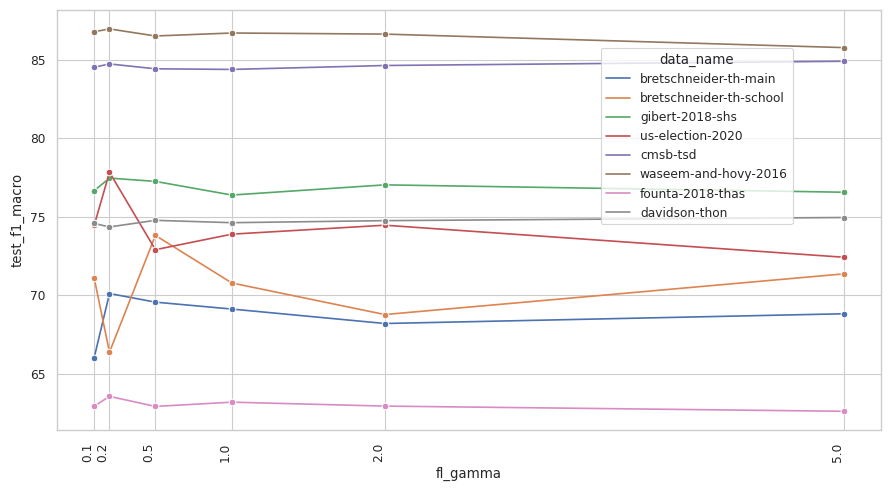

In [179]:
fig, ax = plt.subplots(figsize=(9,5))
df_mean_fl = df_all_mean_results[df_all_mean_results["variant"] == "fl"][["data_name", "fl_gamma", "test_f1_macro"]]
fl_gamma_unique = df_mean_fl.fl_gamma.unique().tolist()
sns.lineplot(x="fl_gamma", y="test_f1_macro", data=df_mean_fl, hue="data_name", marker="o", ax=ax)#

# df_agg_fl = df_all_agg_results[df_all_agg_results["variant"] == "fl"][["data_name", "fl_gamma", "test_f1_macro"]]
# sns.scatterplot(x="fl_gamma", y="test_f1_macro", data=df_agg_fl, color="red", marker="X", ax=ax, s=100)

sns.move_legend(ax, "center right", bbox_to_anchor=(.9, .7)) #
ax.set_xticks(fl_gamma_unique, labels=fl_gamma_unique, rotation=90, ha="right")
ax.figure.tight_layout()
ax.figure.savefig('output_figure.svg', dpi=600, bbox_inches="tight")

55.51

In [76]:
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_per_label_1"]]
def compute_deviation_to_baseline(row):
    baseline_condition = (df_all_mean_results["data_name"] == row["data_name"]) & (df_all_mean_results["variant"] == "baseline")
    baseline_value = df_all_mean_results.loc[baseline_condition, "test_f1_per_label_1"].values[0]
    return row['test_f1_per_label_1'] - baseline_value
df_mean_wce["pos_f1_delta"] = df_mean_wce.apply(lambda row: compute_deviation_to_baseline(row), axis=1)
df_mean_wce

,data_name,wce_alpha,test_f1_per_label_1,pos_f1_delta
40,bretschneider-th-main,0.1,0.00,-42.03
41,bretschneider-th-main,0.25,13.70,-28.33
42,bretschneider-th-main,0.75,43.34,1.31
43,bretschneider-th-main,0.9,46.10,4.07
44,bretschneider-th-main,0.936,48.03,6.00
45,bretschneider-th-main,0.95,47.85,5.82
46,bretschneider-th-main,0.99,43.46,1.43
179,bretschneider-th-school,0.1,0.00,-45.23
180,bretschneider-th-school,0.25,12.58,-32.65
181,bretschneider-th-school,0.75,55.22,9.99


In [82]:
wce_alpha_unique = df_mean_wce.wce_alpha.unique().tolist()
data_name_unique = df_mean_wce.data_name.unique().tolist()
df_wce_delta_by_data = pd.DataFrame(columns=["wce_alpha"] + data_name_unique)
df_wce_delta_by_data["wce_alpha"] = wce_alpha_unique
for data_name in data_name_unique:
    for wce_alpha in wce_alpha_unique:
        conditions = (df_mean_wce["data_name"] == data_name) & (df_mean_wce["wce_alpha"] == wce_alpha)
        if len(df_mean_wce[conditions]) > 0:
            value = df_mean_wce.loc[conditions, "pos_f1_delta"].values[0]
            df_wce_delta_by_data.loc[df_wce_delta_by_data["wce_alpha"] == wce_alpha, data_name] = value
df_wce_delta_by_data = df_wce_delta_by_data.sort_values(by=['wce_alpha']).reset_index(drop=True)
df_wce_delta_by_data

,wce_alpha,bretschneider-th-main,bretschneider-th-school,us-election-2020,waseem-and-hovy-2016
0,0.100,-42.03,-45.23,-37.82,-4.0
1,0.250,-28.33,-32.65,-1.69,-1.7
2,0.625,NaN,NaN,NaN,-0.12
3,0.735,NaN,NaN,NaN,0.18
4,0.750,1.31,9.99,-0.68,-0.34
5,0.875,NaN,NaN,-0.27,NaN
6,0.900,4.07,9.54,3.37,0.23
7,0.920,NaN,12.72,NaN,NaN
8,0.936,6.0,NaN,NaN,NaN
9,0.950,5.82,10.23,NaN,NaN


/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/mounts/Users/cisintern/zhangyaq/anaconda3/envs/pl_env/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


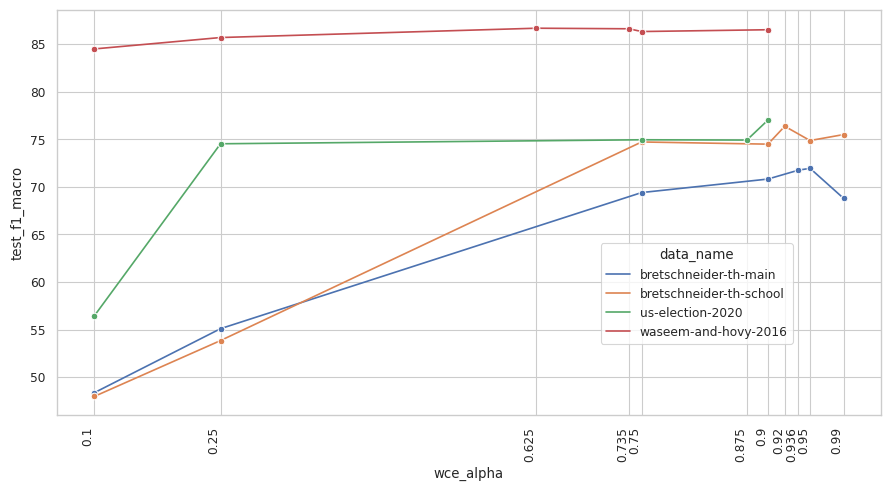

In [205]:
fig, ax = plt.subplots(figsize=(9,5))
# wce_alphas = [0.1, 0.25, 0.75, 0.9, 0.99] #
conditions = (df_all_mean_results["variant"] == "wce") & (df_all_mean_results["num_classes"] == 2) # & df_all_mean_results['wce_alpha'].isin(wce_alphas)
df_mean_wce = df_all_mean_results[conditions][["data_name", "wce_alpha", "test_f1_macro"]]
sns.lineplot(x="wce_alpha", y="test_f1_macro", data=df_mean_wce, hue="data_name", marker="o", ax=ax)

wce_alpha_unique = df_mean_wce.wce_alpha.unique().tolist()
sns.move_legend(ax, "center right", bbox_to_anchor=(.9, .3)) #
ax.set_xticks(wce_alpha_unique, labels=wce_alpha_unique, rotation=90, ha="right")
ax.figure.tight_layout()
ax.figure.savefig('output_figure.svg', dpi=600, bbox_inches="tight")

## Check MLflow runs

In [ ]:
mlrun_ids = []

with open("./outputs/us-election-2020_augmentation_bert-search_seed0_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/us-election-2020_augmentation_bert-search_seed21_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

with open("./outputs/us-election-2020_augmentation_bert-search_seed42_output.txt", "r") as f:
    log_contents = f.readlines()
    mlrun_ids += [log.split("/")[-1][:-2] for log in log_contents if "MLflow Saved Child Search" in log]

mlrun_ids, len(mlrun_ids)

In [55]:
import os
data_runs_dir = f'./mlruns/10/'
run_ids = os.listdir(data_runs_dir)
logs = dict()
for run_id in run_ids:
    ckpt_dir = f"{data_runs_dir}{run_id}/artifacts/model_checkpoints/"
    try:
        ckpt = os.listdir(ckpt_dir)[0]
        logs[run_id] = ckpt
        print(f"{run_id}")
    except NotADirectoryError:
        pass
len(logs)

821e82dc5bd141c59cbe0f023baa544e
8026d9aad00e47d7bee160c0134d65aa
fe3a68cda7e04367bd045e81c5eee78c
9249d6e4459a4adaa34043c09a311f8c
d635e56301264e3eb52869a8c39b47f5
4a1d659627a84c08bc67177c144a6373
47eec5de748e43b3bae37f00221e7a1a
33e16a67749047078ea6df370e21b543
997aab42bf054c08b4377d1a79072e60
2061d3acbe37490682135e8a45415f70
6684ef2005834726bfcd21e46d53128b
b99fbd753a78449fa754b7e9b82070ab
90bba03ec8954f649c6705669733c4d5
770df7a38d77479888bf8e5de153d72f
2833b45d6ac1467c87943b163ffdeba3
4f61bd93c2f64842b2c3f210509be951
2be237bab05547af8d69b6c24f284cca
13dd54e8b1084948bcd026eeadf439cd
a374b27e91d34c7c965e841be4e55e12
7a361abe1ab04d03b5538816a930d8ce
da591d27fce34a14b346439969ea68dc
ecafac2bf5ca4103b6a20db0649cd4ef
0a21317a09ed4d9fad23b4ef44840f2c
6db49e44fc7246caae10a689f10cc55b


24

In [43]:
("a", 1) in [("a", 1), ("b", 2)]

True